# Understanding and Predicting Property Maintenance File

### Project Introduction

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. For this project, my objective is to predict whether a given blight ticket will be paid on time.

All data for this project has been provided through the [Detroit Open Data Portal](https://data.detroitmi.gov/).

Two data files are provided for use in training and validating the models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.


**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 

Source: Applied Machine Learning in Python (Coursera & University of Michigan)

### Data Characteristics (Exploratory Data Analytics)

In [2]:
import pandas as pd
import numpy as np

#### Loading Data

In [3]:
train = pd.read_csv('/Users/mainguyen/Desktop/Data Mining Projects/Blight Violation/train.csv', encoding = "ISO-8859-1")
test = pd.read_csv('/Users/mainguyen/Desktop/Data Mining Projects/Blight Violation/test.csv', encoding = "ISO-8859-1")
address = pd.read_csv('/Users/mainguyen/Desktop/Data Mining Projects/Blight Violation/addresses.csv',encoding = "ISO-8859-1" )
latlons = pd.read_csv('/Users/mainguyen/Desktop/Data Mining Projects/Blight Violation/latlons.csv', encoding = "ISO-8859-1")

/Users/mainguyen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train = pd.merge(train, address, how = 'left', left_on = 'ticket_id', right_on = 'ticket_id')
train = pd.merge(train, latlons, how = 'left', left_on = 'address', right_on = 'address')
train = train[(train['compliance'] == 0) | (train['compliance'] == 1)]
train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233
6,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493
7,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858


The features can be divided into different groups:
+ Location data of the violation, including street name, number, zip code, city, state, country, address, lattitude and logitude
+ Time data: ticket issue date and hearing date
+ Cost data, including fine amount, additional fees (admin fee, state fee, late fee), discount amount, clean up cost
+ Payment infomation (if any): including payment amount, balance due, payment date, payment status and collection status and grafitti status. This data is likely to be removed when building the prediction model to avoid data leakage
+ Label data: compliance 

In [5]:
train.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance', 'address', 'lat',
       'lon'],
      dtype='object')

#### Agency Name

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [7]:
agency = train.groupby('agency_name').count()
agency2 = train[train['compliance'] == 1].groupby('agency_name').count()
agency3 = train[train['compliance'] == 0].groupby('agency_name').count()
df_agency = pd.DataFrame({'Num_Ticket' : agency['ticket_id'], 'Num_compliant': agency2['compliance'],
                          'Num_Non-Compliant' : agency3['compliance']}, index = agency.index )
df_agency['% compliant'] = df_agency['Num_compliant']/df_agency['Num_Ticket']*100 
df_agency['% Non-compliant'] = df_agency['Num_Non-Compliant']/df_agency['Num_Ticket']*100
df_agency

,Num_Ticket,Num_compliant,Num_Non-Compliant,% compliant,% Non-compliant
agency_name,,,,,
"Buildings, Safety Engineering & Env Department",95863,5823.0,90040,6.074294,93.925706
Department of Public Works,52445,4718.0,47727,8.996091,91.003909
Detroit Police Department,4464,588.0,3876,13.172043,86.827957
Health Department,7107,468.0,6639,6.585057,93.414943
Neighborhood City Halls,1,NaN,1,NaN,100.000000


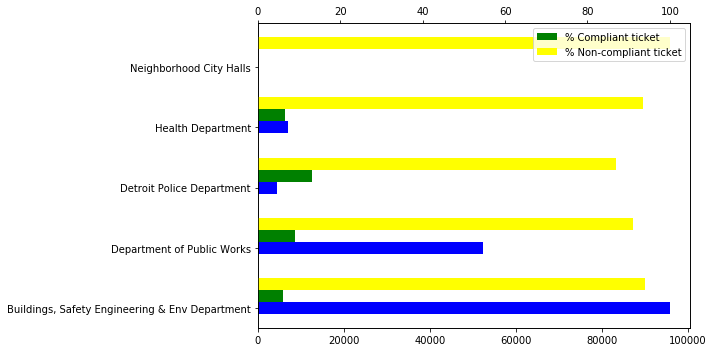

In [8]:
fig, ax1 = plt.subplots(figsize = (10, 5))
xvals = np.arange(len(df_agency))
ax1.barh(xvals, df_agency['Num_Ticket'], height = 0.2, tick_label = df_agency.index, label = 'Total number of ticket', color = 'blue')
ax2 = ax1.twiny()
ax2.barh(xvals + 0.2, df_agency['% compliant'], height = 0.2, label = '% Compliant ticket', color = 'green')
ax2.barh(xvals + 0.2*2, df_agency['% Non-compliant'], height = 0.2, label = '% Non-compliant ticket', color ='yellow')
plt.yticks(size =9)
plt.legend(loc = 'upper right')
plt.tight_layout()

There are 5 totals agency in the training data. The number of ticket are skewed to Building, Safety Engineering and Env Department and Department of Public Works. Other agencies has relatively small number of ticket issued.
The Building, Safety Engineering and Env Department also has smallest portion of compliant ticket and biggest portion of non-compliant ticket. Detroint Police Department has biggest portion of Compliant ticket and smallest portion of non-compliant ticket

#### Inspector name

In [9]:
inspector = train.groupby('inspector_name').count().sort_values(by = 'ticket_id', ascending = False)
len(inspector)

159

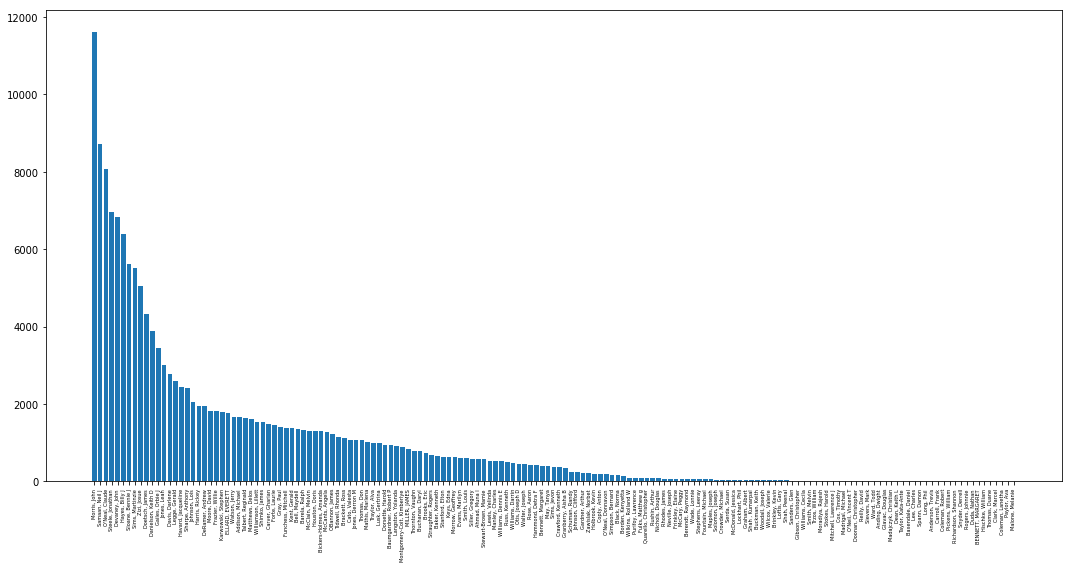

In [10]:
plt.figure(figsize = (15,8))
xvals = range(len(inspector))
plt.bar(xvals, inspector['ticket_id'], tick_label = inspector.index)
plt.xticks(rotation = 90, size =5)
plt.tight_layout()

There are total 159 inspectors who issued the tickets in the training data, more than 30% of them only gave 1 ticket. Again, the number of ticket are skewed to a certain number of inspectors, some of them issued thousands of ticket.

#### Ticket Issued Date

In [11]:
from matplotlib import dates
from datetime import datetime
from datetime import date

In [12]:
train['ticket_issued_date_2'] = pd.to_datetime(train['ticket_issued_date'])
train2 = train.set_index('ticket_issued_date_2')
train2 = train2[train2.index.year >= 2004]
train2.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
ticket_issued_date_2,,,,,,,,,,,,,,,,,,,,,
2004-03-16 11:40:00,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
2004-04-23 12:30:00,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2004-05-01 11:50:00,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233
2004-06-14 14:15:00,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493
2004-06-16 12:30:00,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858


In [13]:
train2_ts_compliant = train2[train2['compliance'] ==1]
g2 = train2_ts_compliant.groupby(pd.Grouper(freq = 'M'))
ts_compliant = g2.count()
train2_ts_non_compliant = train2[train2['compliance'] == 0]
g3 = train2_ts_non_compliant.groupby(pd.Grouper(freq = 'M'))
ts_non_compliant = g3.count()
g = train2.groupby(pd.Grouper(freq="M")) #from this we can create data time series by Month, Quarter and Year
ts = g.count()
ts.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
ticket_issued_date_2,,,,,,,,,,,,,,,,,,,,,
2004-03-31,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,0,1,1,1,1,1
2004-04-30,1,1,1,1,1,1,0,1,1,1,...,1,1,1,0,0,1,1,1,1,1
2004-05-31,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,0,1,1,1,1,1
2004-06-30,3,3,3,3,3,3,0,3,3,3,...,3,0,3,0,0,3,3,3,3,3
2004-07-31,2,2,2,2,2,2,0,2,2,2,...,2,0,2,1,0,2,2,2,2,2


In [14]:
df_ts = pd.DataFrame({'Num_Ticket': ts['ticket_id'], 'Num_compliant': ts_compliant['compliance'], 'Num_non-compliant' :ts_non_compliant['compliance']}, index = ts.index )
df_ts['% compliant'] = df_ts['Num_compliant']/df_ts['Num_Ticket']*100
df_ts['% non-compliant'] = df_ts['Num_non-compliant']/df_ts['Num_Ticket']*100
df_ts =df_ts[df_ts.index.year >=2005]

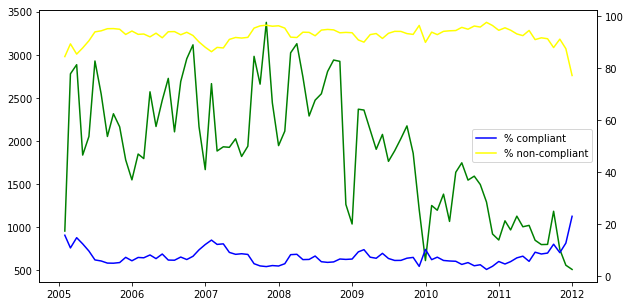

In [15]:
fis,ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df_ts.index, df_ts['Num_Ticket'], '-', color = 'green', label = 'Num of Ticket')
ax2 = ax1.twinx()
ax2.plot(df_ts.index, df_ts['% compliant'], '-', color = 'blue', label = '% compliant')
ax2.plot(df_ts.index, df_ts['% non-compliant'], '-', color = 'yellow', label ='% non-compliant')
ax2.legend()

Observation from the chart above: The number of tickets are decreasing over time, but the portion of non-compliant tickets are quite stable, except before 2005 and after 2011.

#### Hearing Date

In [16]:
train['hearing_date_2'] = pd.to_datetime(train['hearing_date'])
train3 = train.set_index('hearing_date_2')
train3 = train3[train3.index.year >= 2004]
train3.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon,ticket_issued_date_2
hearing_date_2,,,,,,,,,,,,,,,,,,,,,
2005-03-21 10:30:00,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268,2004-03-16 11:40:00
2005-05-06 13:30:00,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118,2004-04-23 12:30:00
2005-03-21 10:30:00,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233,2004-05-01 11:50:00
2005-02-22 15:00:00,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493,2004-06-14 14:15:00
2005-02-22 15:00:00,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858,2004-06-16 12:30:00


In [17]:
g_hearing = train3.groupby(pd.Grouper(freq="M")) #from this we can create data time series by Month, Quarter and Year
ts_hearing = g_hearing.count()
ts_hearing.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon,ticket_issued_date_2
hearing_date_2,,,,,,,,,,,,,,,,,,,,,
2005-01-31,4,4,4,4,4,4,0,4,4,4,...,4,4,0,0,4,4,4,4,4,4
2005-02-28,323,323,323,323,323,323,0,311,323,323,...,216,323,41,0,323,323,323,323,323,323
2005-03-31,1667,1667,1667,1666,1667,1667,0,1619,1667,1667,...,770,1667,239,0,1667,1667,1667,1667,1667,1667
2005-04-30,2122,2122,2122,2121,2122,2122,0,2076,2122,2122,...,922,2122,319,0,2122,2122,2122,2122,2122,2122
2005-05-31,1373,1373,1373,1370,1373,1373,0,1342,1373,1373,...,691,1373,216,0,1373,1373,1373,1373,1373,1373


In [18]:
train3_ts_compliant = train3[train3['compliance'] ==1]
g2 = train3_ts_compliant.groupby(pd.Grouper(freq = 'M'))
ts_hearing_compliant = g2.count()
train3_ts_non_compliant = train3[train3['compliance'] == 0]
g3 = train3_ts_non_compliant.groupby(pd.Grouper(freq = 'M'))
ts_hearing_non_compliant = g3.count()
df_ts_hearing = pd.DataFrame({'Num_Ticket': ts_hearing['ticket_id'], 'Num_compliant': ts_hearing_compliant['compliance'], 'Num_non-compliant' :ts_hearing_non_compliant['compliance']}, index = ts_hearing.index )
df_ts_hearing['% compliant'] = df_ts['Num_compliant']/df_ts['Num_Ticket']*100
df_ts_hearing['% non-compliant'] = df_ts_hearing['Num_non-compliant']/df_ts_hearing['Num_Ticket']*100
df_ts_hearing =df_ts_hearing[df_ts_hearing.index.year >=2005]

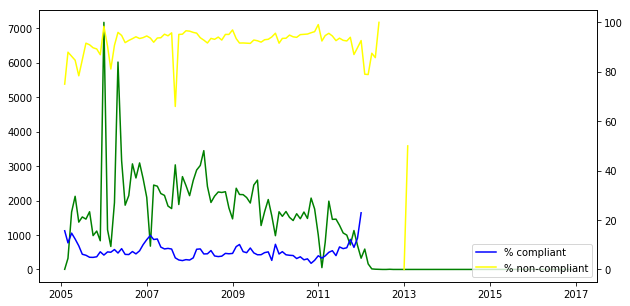

In [19]:
fis,ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df_ts_hearing.index, df_ts_hearing['Num_Ticket'], '-', color = 'green', label = 'Num of Ticket')
ax2 = ax1.twinx()
ax2.plot(df_ts_hearing.index, df_ts_hearing['% compliant'], '-', color = 'blue', label = '% compliant')
ax2.plot(df_ts_hearing.index, df_ts_hearing['% non-compliant'], '-', color = 'yellow', label ='% non-compliant')
ax2.legend()

#### Examine whether the time interval between issued date and hearing date affect the possibility of compliance 

In [20]:
train5 = train[(train['hearing_date'] != np.nan) & (train['ticket_issued_date'] != np.nan)]
train5['time_diff'] = pd.to_datetime(train5['hearing_date']) - train5['ticket_issued_date_2']
train5 = train5[train5['time_diff'].notnull()]

In [21]:
i = 0
time_diff_day = []
while i< len(train5):
    time_diff_day.append(train5.iloc[i]['time_diff'].days)
    i +=1
train5['time_diff_days'] = time_diff_day
train5.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,grafitti_status,compliance_detail,compliance,address,lat,lon,ticket_issued_date_2,hearing_date_2,time_diff,time_diff_days
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268,2004-03-16 11:40:00,2005-03-21 10:30:00,369 days 22:50:00,369
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118,2004-04-23 12:30:00,2005-05-06 13:30:00,378 days 01:00:00,378
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,NaN,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233,2004-05-01 11:50:00,2005-03-21 10:30:00,323 days 22:40:00,323
6,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,NaN,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493,2004-06-14 14:15:00,2005-02-22 15:00:00,253 days 00:45:00,253
7,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,NaN,non-compliant by no payment,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858,2004-06-16 12:30:00,2005-02-22 15:00:00,251 days 02:30:00,251


In [22]:
compliant = train5[train5['compliance'] == 1]
non_compliant = train5[train5['compliance'] == 0]

Text(0.5,1,'non compliant')

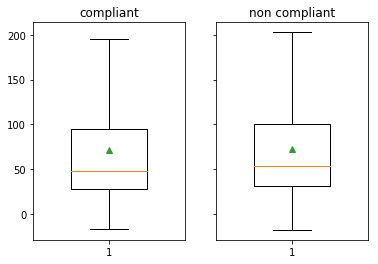

In [23]:
fig, axs = plt.subplots(1,2, sharey = True)
axs[0].boxplot(np.array(compliant['time_diff_days']), showfliers = False, widths = 0.5, showmeans = True)
axs[0].set_title('compliant')
axs[1].boxplot(np.array(non_compliant['time_diff_days']), showfliers = False, widths = 0.5, showmeans = True)
axs[1].set_title('non compliant')

Very slightly difference between compliant and non-compliant tickets in term of the time interval between issued date and hearing date

#### How the location of the violation are distributed?

(-83.5, -82.75)

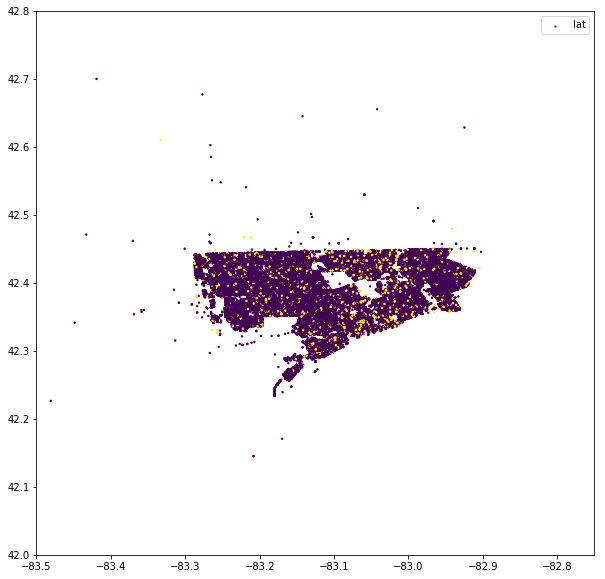

In [24]:
plt.figure(figsize = (10,10))
plt.scatter(train['lon'],train['lat'], c = train['compliance'], s =2)
plt.legend()
plt.gca().set_ylim(42, 42.8)
plt.gca().set_xlim(-83.5, -82.75)

Most violations are in Detroit City, with a small numbers of them are outside of the city. It seems that tickets in the middle of the city are more likely to be compliant.


#### Disposition

In [25]:
disposition = train.groupby('disposition').count()
disposition2 = train[train['compliance'] == 1].groupby('disposition').count()
disposition3 = train[train['compliance'] == 0].groupby('disposition').count()
df_disposition = pd.DataFrame({'Num_Ticket' : disposition['ticket_id'], 'Num_non_compliant': disposition2['compliance'],
                          'Num_Compliant' : disposition3['compliance']}, index = disposition.index )
df_disposition['% non-compliant'] = df_disposition['Num_non_compliant']/df_disposition['Num_Ticket']*100 
df_disposition['% compliant'] = df_disposition['Num_Compliant']/df_disposition['Num_Ticket']*100
df_disposition

,Num_Ticket,Num_non_compliant,Num_Compliant,% non-compliant,% compliant
disposition,,,,,
Responsible (Fine Waived) by Deter,195,195,NaN,100.000000,NaN
Responsible by Admission,13701,3768,9933.0,27.501642,72.498358
Responsible by Default,138340,5285,133055.0,3.820298,96.179702
Responsible by Determination,7644,2349,5295.0,30.729984,69.270016


The tickets we have data only contain 4 types of disposition. Except Responsible by default, other types of disposition have relatively high portion of compliant tickets

#### Fine, Fees and total amount

Text(0.5,1,'non compliant')

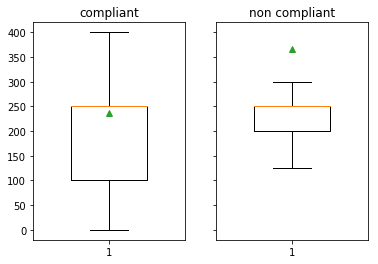

In [26]:
fig, axs = plt.subplots(1,2, sharey = True)
axs[0].boxplot(np.array(compliant['fine_amount']), showfliers = False, widths = 0.5, showmeans = True)
axs[0].set_title('compliant')
axs[1].boxplot(np.array(non_compliant['fine_amount']), showfliers = False, widths = 0.5, showmeans = True)
axs[1].set_title('non compliant')

non-compliant tickets have relatively high amount of non-compliant tickets but the compliant tickets are varied more than the non-compliant tickets.

#### Discount amount

In [27]:
len(compliant[compliant['discount_amount'] != 0])/len(compliant)

0.08730644737993176

In [28]:
len(non_compliant[non_compliant['discount_amount'] != 0])/len(non_compliant)

0.00038455829768860224

In [29]:
discount_yes = train5[train5['discount_amount'] != 0]
len(discount_yes[discount_yes['compliance'] == 1])/len(discount_yes)

0.9459715639810427

Compliant tickets have high percentage of tickets that have discount amount > 0

### Model Selection

#### Preprocessing Data - Train data

In [30]:
#Create new features
train['issue_month'] = [d.month for d in pd.to_datetime(train['ticket_issued_date'])]
train['issue_year'] = [d.year for d in pd.to_datetime(train['ticket_issued_date'])]
train['hearing_month'] = [d.month for d in pd.to_datetime(train['hearing_date'])]
train['hearing_year'] = [d.year for d in pd.to_datetime(train['hearing_date'])]

In [31]:
#Drop the features that we will not use in the model
train_new = train.drop(['violator_name', 'violation_street_number', 'violation_street_name', 'violation_zip_code', 'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state',
                      'zip_code', 'non_us_str_code', 'country', 'violation_code', 'violation_description', 'grafitti_status', 'address', 'collection_status', 'payment_status',
            'payment_amount', 'balance_due', 'payment_date', 'compliance_detail', 'ticket_issued_date', 'hearing_date', 'inspector_name', 'ticket_issued_date_2', 'hearing_date_2'], axis = 1).set_index('ticket_id')

In [32]:
train_new

,agency_name,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,lon,issue_month,issue_year,hearing_month,hearing_year
ticket_id,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,42.390729,-83.124268,3,2004,3.0,2005.0
27586,"Buildings, Safety Engineering & Env Department",Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,42.326937,-83.135118,4,2004,5.0,2005.0
22046,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,42.145257,-83.208233,5,2004,3.0,2005.0
18738,"Buildings, Safety Engineering & Env Department",Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.433466,-83.023493,6,2004,2.0,2005.0
18735,"Buildings, Safety Engineering & Env Department",Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,42.388641,-83.037858,6,2004,2.0,2005.0
18733,"Buildings, Safety Engineering & Env Department",Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,42.388641,-83.037858,6,2004,2.0,2005.0
28204,"Buildings, Safety Engineering & Env Department",Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.435773,-82.963348,7,2004,5.0,2005.0
18743,"Buildings, Safety Engineering & Env Department",Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.395765,-83.022333,7,2004,2.0,2005.0
18741,"Buildings, Safety Engineering & Env Department",Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,42.440190,-83.180488,8,2004,2.0,2005.0


In [33]:
#Create dummy variables
train_disposition_dummy = pd.get_dummies(train_new['disposition']).drop(['Responsible (Fine Waived) by Deter'], axis =1)
train_new = pd.merge(train_new, train_disposition_dummy, how = 'inner', left_index = True, right_index = True).drop(['disposition'], axis = 1)

In [34]:
train_agency_dummy = pd.get_dummies(train_new['agency_name']).drop(['Neighborhood City Halls'], axis = 1)
train_new = pd.merge(train_new, train_agency_dummy, how = 'inner', left_index = True, right_index = True).drop(['agency_name'], axis =1)

In [35]:
#Create label and remove it from train data
label = np.array(train_new['compliance'])
train_new = np.array(train_new.drop(['compliance'], axis =1))

In [36]:
#Make the data fit with machine learning
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

train_new = Imputer().fit_transform(train_new)
X_train, X_test, y_train, y_test = train_test_split(train_new, label)

In [37]:
#Feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression with Grid Search

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

LOR = LogisticRegression()

param_values = {'C': [0.1, 1, 10, 100, 500, 1000]}



In [39]:
grid_LOR_auc = GridSearchCV(LOR, param_grid = param_values, cv = 4, scoring = 'roc_auc', refit = True)
grid_LOR_auc.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
print(grid_LOR_auc.best_score_)
print(grid_LOR_auc.best_params_)

0.7957652871471355
{'C': 500}


### Prediction

#### Prerocessing test data

In [41]:
test = pd.merge(test, address, how = 'left', left_on = 'ticket_id', right_on = 'ticket_id')
test = pd.merge(test, latlons, how = 'left', left_on = 'address', right_on = 'address')

In [42]:
#Create new features
test['issued_month'] = [d.month for d in pd.to_datetime(test['ticket_issued_date'])]
test['issued_year']= [d.year for d in pd.to_datetime(test['ticket_issued_date'])]
test['hearing_month'] = [d.month for d in pd.to_datetime(test['hearing_date'])]
test['hearing_year'] = [d.year for d in pd.to_datetime(test['hearing_date'])]

In [43]:
test = test.drop(['grafitti_status','violation_description', 'city', 'violator_name', 'violation_street_number', 'violation_street_name',
                 'violation_zip_code', 'mailing_address_str_number', 'mailing_address_str_name', 'zip_code', 'non_us_str_code', 'state', 'country', 
                      'violation_code', 'inspector_name', 'address', 'ticket_issued_date', 'hearing_date'], axis =1).set_index('ticket_id')

In [44]:
test_disposition = pd.get_dummies(test['disposition']).drop(['Responsible (Fine Waived) by Admis','Responsible (Fine Waived) by Deter',
                                         'Responsible - Compl/Adj by Default','Responsible - Compl/Adj by Determi', 'Responsible by Dismissal' ], axis =1)
test = pd.merge(test, test_disposition, how = 'inner', left_index = True, right_index = True).drop(['disposition'], axis =1)
    
test_agency = pd.get_dummies(test['agency_name'])
test = pd.merge(test, test_agency, how = 'inner', left_index = True, right_index =True).drop(['agency_name'], axis =1)
test['Health Department'] = 0

In [45]:
test_new = np.array(test)
test_new = Imputer().fit_transform(test_new)
X_test_scaled_new = scaler.fit_transform(test_new)

#### Prediction & Prediction probability

In [46]:
prob = grid_LOR_auc.predict_proba(X_test_scaled_new)[:,1]
pred = grid_LOR_auc.predict(X_test_scaled_new)
test['Probability'] = prob
test['Prediction'] = pred
Result = pd.DataFrame({'Probability': test['Probability'], 'Prediction': test['Prediction']}, index = test.index)

In [56]:
Result.head()

,Probability,Prediction
ticket_id,,
284932,0.000355,0.0
285362,0.000068,0.0
285361,0.000243,0.0
285338,0.000460,0.0
285346,0.000533,0.0
